In [8]:
from utilities import *
from plot_utilities import *
import math
np.random.seed(42)

In [9]:
def gen_gamma_mean(r, eta):
    return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)

def gen_gamma_variance(r, eta):
    mean = gen_gamma_mean(r, eta)
    second_moment = scipy.special.gamma((eta+3.5)/r) / scipy.special.gamma((eta+1.5)/r)
    return second_moment - mean**2

def find_eta_for_target_mean(r, target_mean):
    def objective(eta):
        return (gen_gamma_mean(r, eta) - target_mean)**2
    result = scipy.optimize.minimize_scalar(objective)
    return result.x

def sample_prior(r, eta, size=1):
    '''
    Samples from prior distribution of signal x
    r : shape parameter, must be nonzero
    eta : shape parameter, controls roundedness of peak, must be picked such that beta=(1.5+eta)/r > 0
    size : integer specifying number of samples required

    Note: Theta ~ GenGamma is modeled as the variance of the Normal, scale takes in the standard deviation. 
    This matches up with the original paper on "Sparse Reconstructions ..." by Calvetti et. al. 2020
    '''
    beta = (eta + 1.5)/r
    # assert beta > 0
    vars = stats.gengamma.rvs(a = beta, c = r, size = size)
    x = np.random.normal(scale = np.sqrt(vars), size=size)
    return x

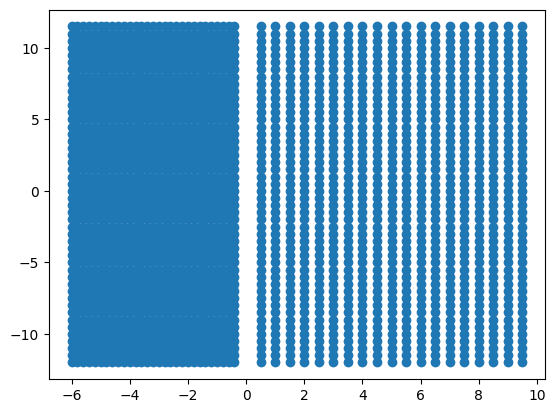

In [77]:
r_vals = np.append(np.arange(-6, 0, 0.2), np.arange(0.2, 6, 0.2))
eta_vals = np.arange(-12, 12, 0.5) # np.append(np.linspace(-5, -0.5, 10), np.linspace(0, 5, 10))
rr, ee = np.meshgrid(r_vals, eta_vals)
plt.scatter(rr, ee)

In [81]:
np.seterr(divide = 'ignore')
np.seterr(invalid = 'ignore') 
cond1, cond2, cond3 = [], [], []

def get_prior_var(r, eta):
    beta = (eta + 1.5)/r
    return scipy.special.gamma(beta + 1/r) / scipy.special.gamma(beta)

df = pd.DataFrame(columns = ['r', 'eta', 'beta', 'beta+1/r', 'empirical_mean', 'empirical_var', 'computed_var', '% error'])

mu = []
var = []
for i in tqdm(range(len(r_vals))):
    r = round_to_sigfigs(r_vals[i])
    for j in range(len(eta_vals)):
        eta = round_to_sigfigs(eta_vals[j])

        beta = (eta+1.5)/r
        if beta <= 0 or np.isnan(beta) or math.isnan(beta): 
            cond1.append((r, eta))
            continue
           

        for _ in range(10):
            x = sample_prior(r, eta, 100000)
            mu.append(np.mean(x))
            var.append(np.var(x))
            computed_var = get_prior_var(r, eta)
            
            df.loc[len(df.index), ] = r, eta, (eta+1.5)/r, ((eta+1.5)/r + 1/r), np.mean(mu), np.mean(var), computed_var, np.abs(np.mean(var) - computed_var)/np.mean(var)  * 100


print(df['% error'].mean(), df.shape)
df.head()


100%|██████████| 48/48 [05:22<00:00,  6.72s/it]

inf (11030, 8)


,r,eta,beta,beta+1/r,empirical_mean,empirical_var,computed_var,% error
0,-6.0,-12.0,1.75,1.583333,-0.001839,0.970052,0.970279,0.023436
1,-6.0,-12.0,1.75,1.583333,-0.000203,0.970188,0.970279,0.009398
2,-6.0,-12.0,1.75,1.583333,0.002274,0.970749,0.970279,0.048424
3,-6.0,-12.0,1.75,1.583333,0.002143,0.970023,0.970279,0.02634
4,-6.0,-12.0,1.75,1.583333,0.001018,0.970126,0.970279,0.015718


<Axes: xlabel='r', ylabel='eta'>

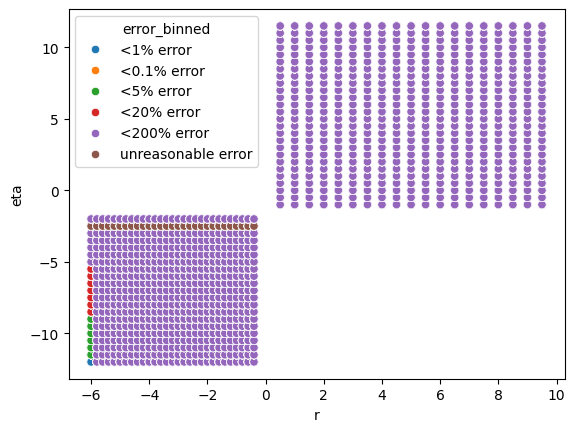

In [80]:
def mapping(x):
    if x < 0.1:
        return '<0.1% error'
    elif x < 1:
        return '<1% error'
    elif x < 5:
        return '<5% error'
    elif x < 20:
        return '<20% error'
    elif x < 200:
        return '<200% error'
    elif x < 1000:
        return '<1000% error'
    else:
        return 'unreasonable error'


df['error_binned'] = df['% error'].apply(mapping)
sns.scatterplot(data=df, x = 'r', y = 'eta', hue = 'error_binned')

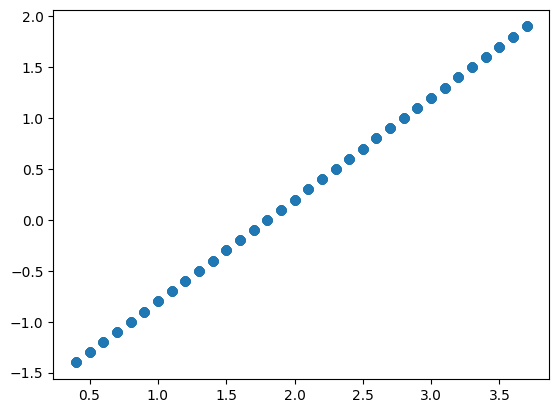

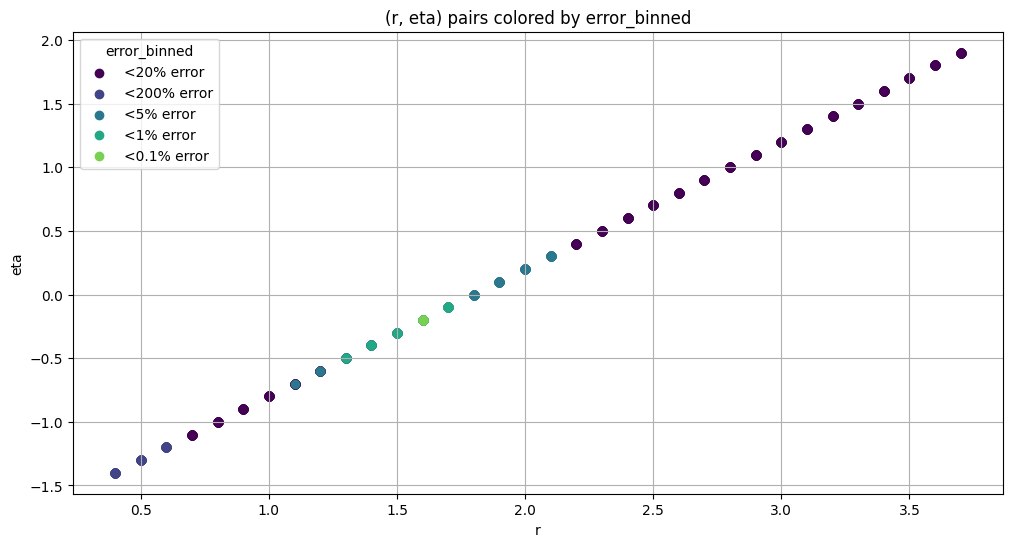

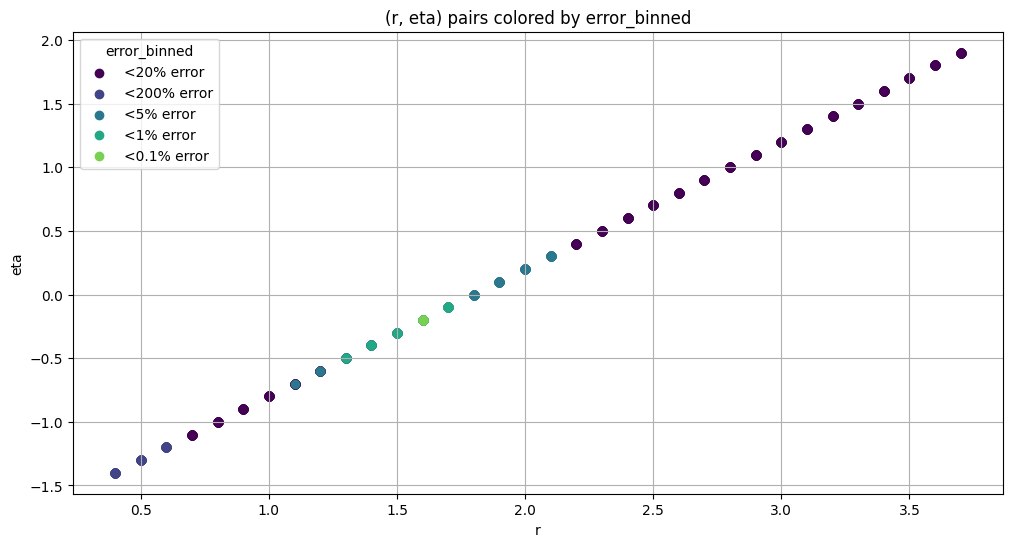

In [33]:
plt.scatter(df['r'], df['eta'])
create_scatter_plot(df, 'error_binned')